## Loading Packages

In [2]:
# yellowbrick version too old
!pip install -U yellowbrick

     |████████████████████████████████| 271 kB 5.9 MB/s 
  Attempting uninstall: yellowbrick
    Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [3]:
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import save,load
from yellowbrick.cluster.elbow import kelbow_visualizer
import seaborn as sns

# NLP 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models import Word2Vec
import gensim

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import utils, layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Ensemble
import xgboost
from sklearn.ensemble import RandomForestClassifier

# Support
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
# wordcloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Settings

In [5]:
#SETTINGS
RANDOM_STATE = 42

#DATASET
TRAIN_SIZE = 0.8

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# TENSORFLOW
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

## Loading Datasets

In [6]:
train_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Train.csv")
val_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Val.csv")
df = pd.concat([train_ds,val_ds]).reset_index()

In [7]:
df.head()

,index,id,tweet,label
0,0,1,The CDC currently reports 99031 deaths. In gen...,real
1,1,2,States reported 1121 deaths a small rise from ...,real
2,2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,4,5,Populous states can generate large case counts...,real


In [8]:
df.label.unique()

array(['real', 'fake'], dtype=object)

In [9]:
df = df.drop('id', axis=1)

## Sanity Check
In this section, we check for:
1.   Null inputs
2.   Duplicated rows



In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8560 entries, 0 to 8559
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   8560 non-null   int64 
 1   tweet   8560 non-null   object
 2   label   8560 non-null   object
dtypes: int64(1), object(2)
memory usage: 200.8+ KB


No null inputs were found

In [11]:
df.duplicated().sum()

0

Viewing the duplicated entry

In [12]:
 df[df.duplicated(keep=False)]

,index,tweet,label


In [13]:
df = df.drop_duplicates()

1 Duplicate was found and dropped

In [14]:
df.label.value_counts()

real    4480
fake    4080
Name: label, dtype: int64

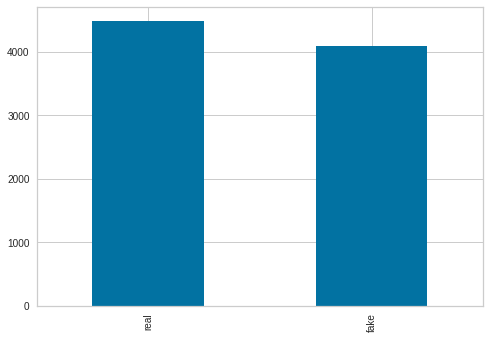

In [15]:
df.label.value_counts().plot(kind='bar')

## Pre-processing

In [16]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lemmer = WordNetLemmatizer()

In [17]:
", ".join(stop_words)


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

## Previewing Tweets

In [18]:
print(df.tweet.sample(15).values)

['Trump Assigns Meat Loaf &amp; Gary Busey To Covid-19 Team https://t.co/mxXbADxhhH'
 '594 new cases of #COVID19Nigeria; Lagos-159 Delta-106 Ondo-44 FCT-34 Edo-34 Oyo-33 Kaduna-33 Enugu-28 Katsina-25 Imo-22 Adamawa-15 Ogun-12 Osun-11 Abia-8 Rivers-6 Nasarawa-5 Bauchi-5 Niger-5 Kebbi-4 Ekiti-3 Plateau-1 Taraba-1 22614 confirmed 7822 discharged 549 deaths https://t.co/JaiUIdu56J'
 '#IndiaFightsCorona: The cumulative testing as on date has reached 37651512. 823992 tests were conducted in the last 24 hours. Such high level of testing on a sustained basis leads to early diagnosis. Details : https://t.co/xI1Zl0U7ZH @MoHFW_INDIA @ICMRDELHI #StaySafe'
 'This 3 year old girl is fighting for her life after getting the coronavirus.'
 'UPDATE: #covid19science #COVID19 South Korea ➡ Epidemic characterised by large clusters of cases ➡ Shincheonji religious group accounted for 48% of cases ➡️High volume of testing &amp; low number of deaths suggests small epidemic 🔰Report https://t.co/lcFch0FxCt http

Creating a column for word count

In [19]:
df['length'] = df['tweet'].apply(lambda x: len(x.split()))

Visualising word count

In [20]:
df['length'].describe()

count    8560.00000
mean       26.94778
std        22.45087
min         3.00000
25%        15.00000
50%        25.00000
75%        37.00000
max      1456.00000
Name: length, dtype: float64

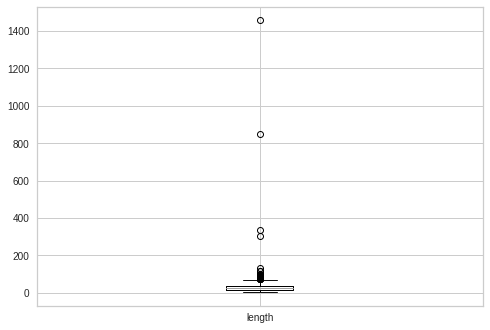

In [21]:
df.boxplot(column=['length'])

We notice outliers with extreme number of words. Previewing outlier articles here.

In [22]:
df[df['length']>150]

,index,tweet,label,length
270,270,"Amoxi"" Capsule made in US is the only medicine...",fake,1456
1109,1109,"Actors"" applauded Macron when he visited the s...",fake,847
6306,6306,Man visited Albany N.Y. days before dying from...,fake,336
8153,1733,I'm so happy that we’re able to do something v...,real,304


In [23]:
for tweet in df['tweet'][df['length']>150].values:
  print(tweet)

Amoxi" Capsule made in US is the only medicine that can completely cure COVID-19.
Egyptian Health Minister arrive in Italy with secret coronavirus cure.
 Dr Charles Lieber a Harvard professor has been arrested in the USA for manufacturing the coronavirus and selling it to China. A video news report from WCVB a TV station in Boston Massachusetts is shared with the Facebook post.
Mountain Matterhorn in Switzerland was lit in three colours of Indian flag as a token of gratitude to India for sending Hydroxychloroquine.
Al-Azhar Imam said he is considering exceptions on Ramadan fasting as the research says that the mouth must be kept wet to prevent COVID-19
 Japanese Nobel Tasuku Honjo says coronavirus was created in the Wuhan laboratory
A man collapses in 5 minutes after showing COVID-19 symptoms in India.
Celebrities spreading misinformation about coronavirus and the Janata curfew in India.
 Multiple posts shared repeatedly on Facebook and Twitter since March 2020 claim that Israel has re

We will remove the outlier articles.

In [24]:
df = df[df['length'] < 150]

(0.0, 200.0)

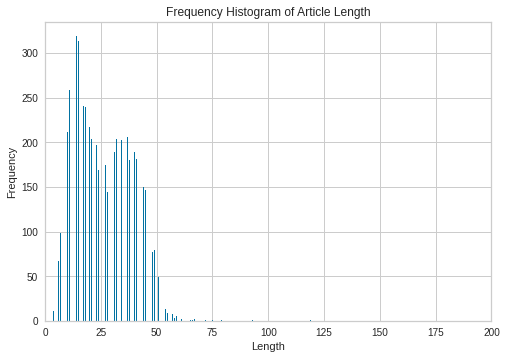

In [25]:
#plt.scatter(df.index,df['length'])
plt.hist(df['length'],bins=500)
plt.gca().set(title='Frequency Histogram of Article Length', ylabel='Frequency', xlabel='Length')
plt.xlim(0,200)


## Text Cleaning

- Transform to lowercase
- Remove trailing white spaces
- Remove stopwords
- Stem and lemmatize words to root form

In [26]:
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmer.lemmatize(stemmer.stem(token)))
    return " ".join(tokens)

In [27]:
df.tweet = df.tweet.apply(lambda x:preprocess(x))

In [28]:
print(df.tweet.sample(15).values)

['herd immun strategi uneth unlik success uk warn scientist long covid suffer call recognit'
 'first night republican nation convent roundup recent claim realdonaldtrump republican covid 19 economi'
 '338 new case covid19 177 lago 64 kano 21 fct 16 river 14 plateau 11 oyo 9 katsina 4 jigawa 4 kaduna 3 abia 3 bauchi 3 borno 2 gomb 2 akwa ibom 2 delta 1 ondo 1 kebbi 1 sokoto 5959 case covid19 nigeria discharg 1594 death 182'
 'covid 19 updat four addit probabl case covid 19 link new outbreak auckland one new case manag isol four probabl case await test result full isol'
 'acc peopl wear facemask exercis sweat make mask wet damp may reduc abil breath comfort exercis outsid kind maintain distanc 2m el may workout home covid19 covid 19 covid 19'
 'presid done job done job begin peopl would still aliv peopl make look data'
 'coronavirus may spread due consumpt bat soup accord scientist'
 'ground report arvindkejriw ji plea tell u suffer delhi delhifightscorona arvindkejriw'
 'lock 4pm updat 

## Train Test Split

In [29]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)
print("TRAIN size: ", len(df_train))
print("TEST size: ", len(df_test))

TRAIN size:  6844
TEST size:  1712


In [30]:
df_train.head()

,index,tweet,label,length
625,625,nasser ziberi test posit covid 19,fake,6
5520,5520,protect mask five time expens french tobacconi...,fake,15
3948,3948,captshaktilumba jabalpursafeti free67847229 as...,fake,59
6996,576,say wisconsin person elect caus surg new coron...,fake,12
5815,5815,drink pigeon membran slurri cure covid 19,fake,7


## Word2Vec Model

### Building Document

In [31]:
documents = [tweet.split() for tweet in df_train.tweet]


### Initialising word2vec model with hyperparameters

In [32]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

# For newer version of word2vec
# w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
#                                             window=W2V_WINDOW, 
#                                             min_count=W2V_MIN_COUNT, 
#                                             workers=8)

### Building Vocab

In [33]:
w2v_model.build_vocab(documents)


### Training word2vec model

In [34]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)


(2663990, 3787264)

In [35]:
w2v_model.wv.most_similar("covid")


[('coronaupd', 0.3602452874183655),
 ('drhvoffic', 0.31854698061943054),
 ('admit', 0.29741328954696655),
 ('acquir', 0.2968937158584595),
 ('covidupd', 0.29525259137153625),
 ('coronavirusindia', 0.2921895384788513),
 ('unknown', 0.2703617811203003),
 ('main', 0.2661912143230438),
 ('paulo', 0.2659401297569275),
 ('link', 0.2657371759414673)]

## Tokenize Text

In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total unique words", vocab_size)

Total unique words 11088


Previewing top 50 words

In [37]:
token_count = dict(tokenizer.word_counts)
token_count_df = pd.DataFrame(dict(sorted(token_count.items(), key=lambda item: item[1], reverse=True)),index=["Count"]).T
token_count_df.head(2)

,Count
covid,2538
case,2176


### Converting text to sequence of integers

In [38]:
x_train_word2vec = tokenizer.texts_to_sequences(df_train.tweet)
x_test_word2vec = tokenizer.texts_to_sequences(df_test.tweet)

## Padding

In [39]:
x_train_word2vec  = pad_sequences(x_train_word2vec , maxlen=SEQUENCE_LENGTH)
x_test_word2vec  = pad_sequences(x_test_word2vec , maxlen=SEQUENCE_LENGTH)

## Label Encoding

In [40]:
labels = df_train.label.unique().tolist()
labels

['fake', 'real']

In [41]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train_word2vec  = encoder.transform(df_train.label.tolist())
y_test_word2vec  = encoder.transform(df_test.label.tolist())

y_train_word2vec  = y_train_word2vec .reshape(-1,1)
y_test_word2vec  = y_test_word2vec .reshape(-1,1)


In [42]:
print("x_train", x_train_word2vec .shape)
print("y_train", y_train_word2vec .shape)

print("x_test", x_test_word2vec .shape)
print("y_test", y_test_word2vec .shape)

x_train (6844, 300)
y_train (6844, 1)
x_test (1712, 300)
y_test (1712, 1)


## Embedding Matrix

In [43]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Weights for embedding layer

In [44]:
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(11088, 300)


## TF-IDF Vectorisation

In [45]:
documents = [tweet.split() for tweet in df_train.tweet]

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(df_train.tweet)
x_test_tfidf = tfidf_vectorizer.transform(df_test.tweet)

df_tfidf_sklearn = pd.DataFrame(x_train_tfidf.toarray(),columns=tfidf_vectorizer.get_feature_names())
df_tfidf_sklearn.sort_index().round(decimals=5)
df_tfidf_sklearn 

,00,000,006,00ice,00pm,01,011,0141,02,03,033,04,04051952n,041461636,047738491,05,054,056260928,05am,06,062454254,063661060,07,0710,0730,08,0800,0818,0881911,09,0940,10,100,1000,10000,100000,10001,100046,1000frolli,1000th,...,yr,yumzer,yup,yvonn,ywoga,zacbissonnett,zack,zambal,zambia,zamfara,zaria,zealand,zedwar,zee,zeenew,zekiri,zero,zev,zhangzhan,zhoushan,ziberi,zika,zillionair,zinc,zino,ziplock,zithromax,zomato,zombi,zone,zoo,zoodirector,zookeep,zoolog,zoom,zoonot,zuckoff,zurich,zydus,zyphr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.644215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
df_tfidf_sklearn = df_tfidf_sklearn.stack().reset_index()
df_tfidf_sklearn = df_tfidf_sklearn.rename(columns={0:'tfidf', 'level_0': 'id','level_1': 'term', 'level_2': 'term'})
df_tfidf_sklearn

,id,term,tfidf
0,0,00,0.0
1,0,000,0.0
2,0,006,0.0
3,0,00ice,0.0
4,0,00pm,0.0
...,...,...,...
75667259,6843,zoonot,0.0
75667260,6843,zuckoff,0.0
75667261,6843,zurich,0.0
75667262,6843,zydus,0.0


In [48]:
df_tfidf_sklearn.sort_values(by=['id','tfidf'], ascending=[True,False]).groupby(['id']).head(10)


,id,term,tfidf
7401,0,nasser,0.644215
11036,0,ziberi,0.644215
8212,0,posit,0.284045
10015,0,test,0.196617
488,0,19,0.164663
...,...,...,...
75656208,6843,00,0.000000
75656209,6843,000,0.000000
75656210,6843,006,0.000000
75656211,6843,00ice,0.000000


In [49]:
specificid = df_tfidf_sklearn.sort_values(by=['id','tfidf'], ascending=[True,False]).groupby(['id']).head(20)
specificid[specificid['id'].isin({847})]


,id,term,tfidf
9364630,847,1215,0.448347
9372064,847,number,0.337164
9372196,847,organ,0.268600
9373044,847,receiv,0.262127
9371054,847,level,0.240964
9375459,847,zealand,0.240253
9367591,847,care,0.230665
9364920,847,19,0.229197
9375362,847,world,0.223143
9368228,847,covid,0.213466


## Exploratory Data Analysis

### Length Analysis

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


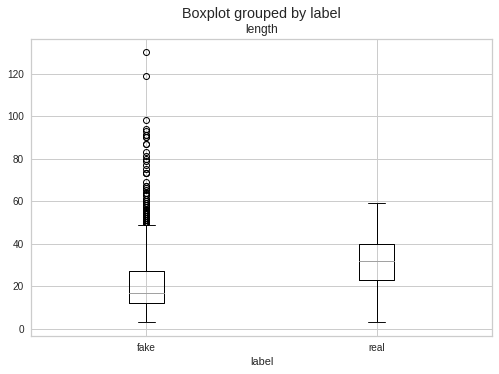

In [50]:
df_train[df_train["length"] < 150].boxplot(column=["length"], by="label")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

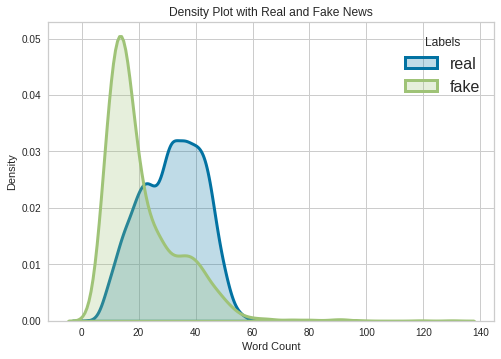

In [51]:
labels = ['real','fake']

for label in labels:
  subset = df_train[df_train["label"] == label]
  sns.distplot(subset[subset['length']<150]['length'], hist = False, kde = True,
                  kde_kws = {'shade': True, 'linewidth': 3}, label = label)

plt.legend(prop={'size': 16}, title = 'Labels')
plt.title('Density Plot with Real and Fake News')
plt.xlabel('Word Count')
plt.ylabel('Density')

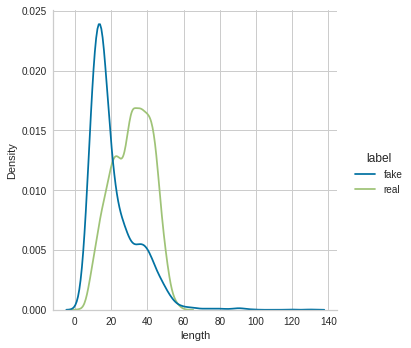

In [52]:
sns.displot(data=df_train[df_train['length']<150], x="length", hue="label", kind="kde")

Fake news tends to be short than real news. 

### Kmeans Clustering

### Cluster on words

In [53]:
X = w2v_model.wv.vectors
kmeans = KMeans(random_state = 42)

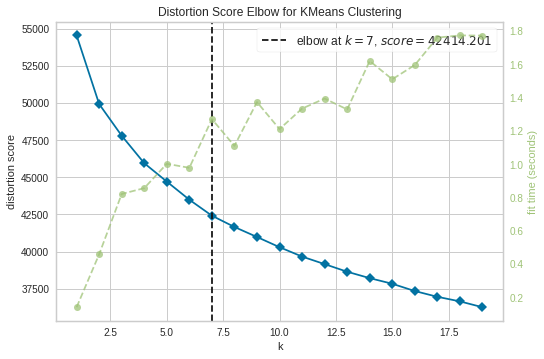

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b8e93db90>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=19,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto', random_state=42,
                                  tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='distortion', timings=True)

In [60]:
kelbow_visualizer(kmeans, X,k=(1,20))

### Cluster on Documents

In [59]:
#kelbow_visualizer(kmeans, x_train_tfidf, k=(1,20))

KeyboardInterrupt: ignored

K-means clustering doesn't seem to work sell for both words and documents. The variety in meanings (of words) and topics (for documents) is probably the reason why we get a fairly smooth curve plot with the elbow method

### Cluster on words

K-means clustering doesn't seem to work sell for both words and documents. The variety in meanings (of words) and topics (for documents) is probably the reason why we get a fairly smooth curve plot with the elbow method

### Word Cloud


In [62]:
#cloud_stop = stop_words.extend(["covid", "coronavirus", "case", "covid-19", "peopl", "covid19"])
cloud_stop = set(STOPWORDS)
cloud_stop.update(["covid", "coronavirus", "case", "covid-19", "peopl", "covid19", "amp"])

In [63]:
# for all text
all_text = " ".join(tweet for tweet in df.tweet)
wordcloud = WordCloud(stopwords=cloud_stop, background_color="white").generate(all_text)

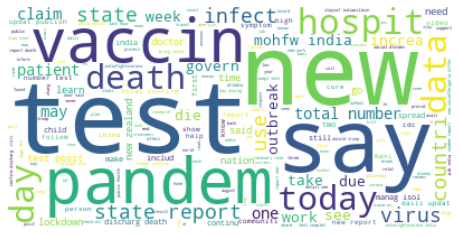

In [64]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [65]:
# for fakes
fake_text = " ".join(tweet for tweet in df[df['label']== 'fake'].tweet)
fake_cloud = WordCloud(stopwords=cloud_stop, background_color="white").generate(fake_text)

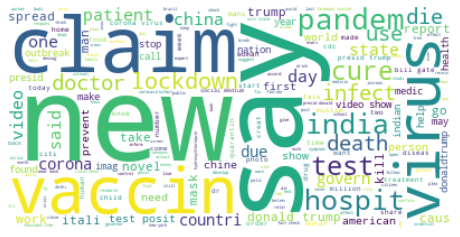

In [66]:
plt.imshow(fake_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [67]:
# for real
real_text = " ".join(tweet for tweet in df[df['label']== 'real'].tweet)
real_cloud = WordCloud(stopwords=cloud_stop, background_color="white").generate(real_text)

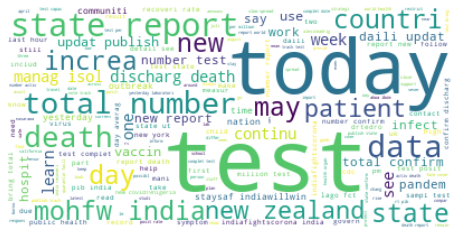

In [68]:
plt.imshow(real_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Model Building

## Deep Learning : TextCNN

### Using Word2Vec Vectorisation

In [69]:
cnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers. Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_word2vec_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          3326400   
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          192128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,519,829
Trainable params: 193,429
Non-trainable params: 3,326,400
________________________________________

In [70]:
cnn_word2vec_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy','Precision','Recall','AUC'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = cnn_word2vec_model.fit(x_train_word2vec , y_train_word2vec ,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/32
7/7 [==============================] - 34s 356ms/step - loss: 0.5308 - accuracy: 0.7514 - precision: 0.7812 - recall: 0.7307 - auc: 0.8120 - val_loss: 0.3084 - val_accuracy: 0.8628 - val_precision: 0.8507 - val_recall: 0.9096 - val_auc: 0.9459 - lr: 0.0010
Epoch 2/32
7/7 [==============================] - 2s 215ms/step - loss: 0.2992 - accuracy: 0.8716 - precision: 0.8756 - recall: 0.8802 - auc: 0.9471 - val_loss: 0.2755 - val_accuracy: 0.8847 - val_precision: 0.9046 - val_recall: 0.8830 - val_auc: 0.9544 - lr: 0.0010
Epoch 3/32
7/7 [==============================] - 2s 214ms/step - loss: 0.2658 - accuracy: 0.8883 - precision: 0.9045 - recall: 0.8799 - auc: 0.9570 - val_loss: 0.2468 - val_accuracy: 0.8920 - val_precision: 0.8974 - val_recall: 0.9069 - val_auc: 0.9628 - lr: 0.0010
Epoch 4/32
7/7 [==============================] - 1s 212ms/step - loss: 0.2341 - accuracy: 0.9040 - precision: 0.9244 - recall: 0.8898 - auc: 0.9662 - val_loss: 0.2367 - val_accuracy: 0.8905 - val_p

In [71]:
score_cnn_word2vec = cnn_word2vec_model.evaluate(x_test_word2vec , y_test_word2vec , batch_size=BATCH_SIZE)
print()

print("LOSS:",score_cnn_word2vec[0])
print("ACCURACY:",score_cnn_word2vec[1])
print("PRECISION:",score_cnn_word2vec[2])
print("RECALL:",score_cnn_word2vec[3])
print("AUC:",score_cnn_word2vec[4])

2/2 [==============================] - 0s 315ms/step - loss: 0.2075 - accuracy: 0.9130 - precision: 0.9104 - recall: 0.9198 - auc: 0.9749

LOSS: 0.20752188563346863
ACCURACY: 0.9129672646522522
PRECISION: 0.9104308485984802
RECALL: 0.9198167324066162
AUC: 0.9748678803443909


### Using TF-IDF Vectorisation

In [72]:
x_train_tfidf.shape

(6844, 11056)

In [73]:
cnn_tfidf_model = tf.keras.Sequential([
    layers.Conv1D(128, 5, activation='relu', input_shape=(None,1)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_tfidf_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 128)         768       
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,069
Trainable params: 2,069
Non-trainable params: 0
_________________________________________________________________


In [74]:
def batch_generator(x, y, batch_size):
    samples_per_epoch = x.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:].toarray()
        y_batch = y[min(index_batch):max(index_batch)+1]
        counter += 1
        x_batch = np.expand_dims(x_batch, axis=2)
        #print(X_batch.shape)
        yield x_batch, np.array(y_batch)
        if (counter > number_of_batches):
            counter=0

In [75]:
y_train = list(y_train_word2vec)

In [76]:
cnn_tfidf_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy','Precision','Recall','AUC'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = cnn_tfidf_model.fit(batch_generator(x_train_tfidf, y_train, 32),epochs=5,steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/5
213/213 [==============================] - 14s 60ms/step - loss: 0.6895 - accuracy: 0.5529 - precision: 0.6022 - recall: 0.4462 - auc: 0.5949
Epoch 2/5
213/213 [==============================] - 13s 60ms/step - loss: 0.6746 - accuracy: 0.6113 - precision: 0.6401 - recall: 0.5993 - auc: 0.6480
Epoch 3/5
213/213 [==============================] - 13s 60ms/step - loss: 0.6566 - accuracy: 0.6235 - precision: 0.6226 - recall: 0.7243 - auc: 0.6574
Epoch 4/5
213/213 [==============================] - 13s 60ms/step - loss: 0.6516 - accuracy: 0.6251 - precision: 0.6213 - recall: 0.7388 - auc: 0.6604
Epoch 5/5
213/213 [==============================] - 13s 60ms/step - loss: 0.6508 - accuracy: 0.6262 - precision: 0.6227 - recall: 0.7377 - auc: 0.6610


In [77]:
x_test_tfidf = np.expand_dims(x_test_tfidf.toarray(), axis=2)
score_cnn_tfidf = cnn_tfidf_model.evaluate(x_test_tfidf, y_test_word2vec, batch_size=32)

print()

print("LOSS:",score_cnn_tfidf [0])
print("ACCURACY:",score_cnn_tfidf [1])
print("PRECISION:",score_cnn_tfidf [2])
print("RECALL:",score_cnn_tfidf [3])
print("AUC:",score_cnn_tfidf [4])

54/54 [==============================] - 2s 28ms/step - loss: 0.6602 - accuracy: 0.6051 - precision: 0.5807 - recall: 0.8121 - auc: 0.6575

LOSS: 0.6602473855018616
ACCURACY: 0.605140209197998
PRECISION: 0.5806716084480286
RECALL: 0.812142014503479
AUC: 0.6574912667274475


## Deep Learning: Directional LSTM
Model performed better with a 0.5 dropout.

### Using Word2Vec Vectorisation

In [78]:
lstm_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.LSTM(64, return_sequences=True, dropout=0.5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_word2vec_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          3326400   
                                                                 
 lstm (LSTM)                 (None, 300, 64)           93440     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,420,501
Trainable params: 94,101
Non-trainable params: 3,326,400
_______________________________________

In [79]:
lstm_word2vec_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy','Precision','Recall','AUC'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

lstm_word2vec_history = lstm_word2vec_model.fit(x_train_word2vec , y_train_word2vec ,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/32
7/7 [==============================] - 9s 983ms/step - loss: 0.5943 - accuracy: 0.6814 - precision: 0.6587 - recall: 0.8149 - auc: 0.7847 - val_loss: 0.4448 - val_accuracy: 0.7927 - val_precision: 0.7840 - val_recall: 0.8590 - val_auc: 0.8993 - lr: 0.0010
Epoch 2/32
7/7 [==============================] - 6s 887ms/step - loss: 0.4002 - accuracy: 0.8191 - precision: 0.8164 - recall: 0.8452 - auc: 0.9046 - val_loss: 0.3796 - val_accuracy: 0.8467 - val_precision: 0.8974 - val_recall: 0.8138 - val_auc: 0.9297 - lr: 0.0010
Epoch 3/32
7/7 [==============================] - 6s 913ms/step - loss: 1.7972 - accuracy: 0.8474 - precision: 0.8801 - recall: 0.8207 - auc: 0.9151 - val_loss: 3.6175 - val_accuracy: 0.8482 - val_precision: 0.8953 - val_recall: 0.8191 - val_auc: 0.9125 - lr: 0.0010
Epoch 4/32
7/7 [==============================] - 6s 920ms/step - loss: 3.4636 - accuracy: 0.8324 - precision: 0.8525 - recall: 0.8229 - auc: 0.8934 - val_loss: 5.9292 - val_accuracy: 0.8015 - val_pr

In [80]:
score_lstm_word2vec = lstm_word2vec_model.evaluate(x_test_word2vec , y_test_word2vec , batch_size=BATCH_SIZE)
print()

print("LOSS:",score_lstm_word2vec[0])
print("ACCURACY:",score_lstm_word2vec[1])
print("PRECISION:",score_lstm_word2vec[2])
print("RECALL:",score_lstm_word2vec[3])
print("AUC:",score_lstm_word2vec[4])

2/2 [==============================] - 0s 133ms/step - loss: 0.3088 - accuracy: 0.8697 - precision: 0.9062 - recall: 0.8305 - auc: 0.9437

LOSS: 0.3087557852268219
ACCURACY: 0.8697429895401001
PRECISION: 0.90625
RECALL: 0.8304696679115295
AUC: 0.9437242150306702


### Using TF-IDF Vectorisation 

In [85]:
# Prepare data
y_train = list(y_train_word2vec)
x_test_tfidf = np.expand_dims(x_test_tfidf, axis=2)

In [86]:
lstm_tfidf_model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, dropout=0.5, activation='relu', input_shape=(None,1)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_tfidf_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, None, 64)          16896     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 17,557
Trainable params: 17,557
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_tfidf_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy','Precision','Recall','AUC'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

bilstm_word2vec_history = lstm_tfidf_model.fit(batch_generator(x_train_tfidf, y_train, 32),epochs=5,steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/5
 13/213 [>.............................] - ETA: 1:36:23 - loss: 0.6939 - accuracy: 0.4615 - precision: 0.4750 - recall: 0.8301 - auc: 0.4103

In [ ]:
score_lstm_tfidf = lstm_tfidf_model.evaluate(x_test_tfidf, y_test_word2vec, batch_size=32)

print()

print("LOSS:",score_lstm_tfidf [0])
print("ACCURACY:",score_lstm_tfidf [1])
print("PRECISION:",score_lstm_tfidf [2])
print("RECALL:",score_lstm_tfidf [3])
print("AUC:",score_lstm_tfidf [4])

## Deep Learning: Bi-Directional LSTM

### Using Word2Vec Vectorisation

In [ ]:
bilstm_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.5, activation='relu')),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bilstm_word2vec_model.summary()

In [ ]:
bilstm_word2vec_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy','Precision','Recall','AUC'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

bilstm_word2vec_history = bilstm_word2vec_model.fit(x_train_word2vec , y_train_word2vec ,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
score_bilstm_word2vec = bilstm_word2vec_model.evaluate(x_test_word2vec , y_test_word2vec , batch_size=BATCH_SIZE)
print()

print("LOSS:",score_bilstm_word2vec[0])
print("ACCURACY:",score_bilstm_word2vec[1])
print("PRECISION:",score_bilstm_word2vec[2])
print("RECALL:",score_bilstm_word2vec[3])
print("AUC:",score_bilstm_word2vec[4])

### Using TF-IDF Vectorisation 

In [ ]:
bilstm_tfidf_model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(100, return_sequences=True, activation='relu')),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bilstm_tfidf_model.summary()

In [ ]:
bilstm_tfidf_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy','Precision','Recall','AUC'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

bilstm_word2vec_history = bilstm_tfidf_model.fit(batch_generator(x_train_tfidf, y_train, 32),epochs=5,steps_per_epoch=x_train_tfidf.shape[0]/32)

In [ ]:
score_bilstm_tfidf = bilstm_tfidf_model.evaluate(x_test_tfidf, y_test_word2vec, batch_size=32)

print()

print("LOSS:",score_bilstm_tfidf [0])
print("ACCURACY:",score_bilstm_tfidf [1])
print("PRECISION:",score_bilstm_tfidf [2])
print("RECALL:",score_bilstm_tfidf [3])
print("AUC:",score_bilstm_tfidf [4])

## Deep Learning: CNN-LSTM

### Using Word2Vec Vectorisation

In [ ]:
cnnlstm_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.Conv1D(128, 5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(100, return_sequences=True, dropout=0.5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnnlstm_word2vec_model.summary()

In [ ]:
cnnlstm_word2vec_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy','Precision','Recall','AUC'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

cnnlstm_word2vec_history = cnnlstm_word2vec_model.fit(x_train_word2vec , y_train_word2vec ,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
score_cnnlstm_word2vec = cnnlstm_word2vec_model.evaluate(x_test_word2vec , y_test_word2vec , batch_size=BATCH_SIZE)
print()

print("LOSS:",score_cnnlstm_word2vec[0])
print("ACCURACY:",score_cnnlstm_word2vec[1])
print("PRECISION:",score_cnnlstm_word2vec[2])
print("RECALL:",score_cnnlstm_word2vec[3])
print("AUC:",score_cnnlstm_word2vec[4])

## Deep Learning: LSTM-CNN

### Using Word2Vec Vectorisation

In [ ]:
lstmcnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.LSTM(100, return_sequences=True, dropout=0.5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstmcnn_word2vec_model.summary()

In [ ]:
lstmcnn_word2vec_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy','Precision','Recall','AUC'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

lstmcnn_word2vec_history = lstmcnn_word2vec_model.fit(x_train_word2vec , y_train_word2vec ,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
score_lstmcnn_word2vec = lstmcnn_word2vec_model.evaluate(x_test_word2vec , y_test_word2vec , batch_size=BATCH_SIZE)
print()

print("LOSS:",score_lstmcnn_word2vec[0])
print("ACCURACY:",score_lstmcnn_word2vec[1])
print("PRECISION:",score_lstmcnn_word2vec[2])
print("RECALL:",score_lstmcnn_word2vec[3])
print("AUC:",score_lstmcnn_word2vec[4])